## 1: CSP

set up

In [3]:
import itertools
import random
import re
import string
from collections import defaultdict, Counter
from functools import reduce
from operator import eq, neg
from sortedcontainers import SortedSet
import yfinance as yf
import string
#import search
#from utils import argmin_random_tie, count, first, extend
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
def count(seq):
    """Count the number of items in sequence that are interpreted as true."""
    return sum(map(bool, seq))

csp class

In [5]:
class CSP():  # class CSP(search.problem):
    def __init__(self, variables, domains, neighbors, constraints):
        #super().__init__(())
        self.variables = variables or list(domains.keys())
        self.domains = domains
        self.neighbors = neighbors
        self.constraints = constraints
        self.curr_domains = None
        self.nassigns = 0

    def assign(self, var, val, assignment):
        assignment[var] = val
        self.nassigns += 1
    
    def unassign(self, var, aasignment):
        if var in aasignment:
            del aasignment[var]

    def nconflicts(self, var, val, assignment):
        """Return the number of conflicts var=val has with other variables."""
        def conflict(var2):
            return var2 in assignment and not self.constraints(var, val, var2,  assignment[var2])
            
        return sum(conflict(v) for v in self.neighbors[var])

    def display(self, assignment):
        print(assignment)  # Subclasses can print in a prettier way, or display with a GUI

    def actions(self, state):
        """ return a list for possible actions : non-conflicting assignments to an unassigned var """
        if len(state) == len(self.variables):
            return []
        else:
            assignment = dict(state)
            var = first([v for v in self.variables if v not in assignment])
            return [(var, val) for val in self.domains[var] 
                    if self.nconflicts(var, val, assignment) == 0]

    def result(self, state, action):
        """ perform a single action and return the new state """
        (var, val) = action 
        return state + ((var, val),)

    def goal_test(self, state):
        assignment = dict(state)
        return ( len(self.variables) == len(assignment) and 
                 all(self.nconflicts(variables, assignment[variables], assignment) == 0
                    for variables in self.variables) )
                
    # these are for constaint propagation
    
    def support_pruning(self):
        """ to prune values from domain """
        if self.curr_domains is None:
            # Ensures that domains can be pruned without modifying the original self.domains
            self.curr_domains = {v: list(self.domains[v]) for v in self.variables}

    def suppose(self, var, val):
        self.support_pruning()
        removals = [(var, a) for a in self.curr_domains[var] if a != val]
        self.curr_domains[var] =  [val]
        return removals

    def prune(self, var, val, removals):
        self.curr_domains[var].remove(val)
        if removals is not None:
            removals.append((var, val))

    def choices(self, var):
        return (self.curr_domains or self.domains)[var] # 2nd will works only if curr_domains is None

    def infer_assignment(self):
        """ returns the variables that has a singleton in its domain """
        self.support_pruning()
        return {v: self.curr_domains[v][0] for v in self.variables if 1 == len(self.curr_domains[v])}

    def restore(self, removals):
        """ Restores previously pruned values in case of backtracking """
        for B, b in removals:
            self.curr_domains[B].append(b)

    # these is for min_conflicrs search

    def conflicted_var(self, current):
        """ return a list of variables in current assignment that are in conflicts """
        return [var for var in self.variables if self.nconflicts(var, current[var], current) != 0]
                             

## 2: Alorithms

AC3 alogrithm

In [8]:
def dom_j_up(csp, queue):
    return SortedSet(queue, key= lambda t: neg(len(csp.curr_domains[t[1]])))
    
def AC3(csp , queue= None, removals=None, arc_heuristic = dom_j_up):
    
    def revise(Xi, Xj, checks = 0):
        revised = False
        for x in csp.curr_domains[Xi][:]:
            conflict = True
            for y in csp.curr_domains[Xj]:
                if csp.constraints(Xi, x , Xj, y):
                    conflict = False
                checks += 1
                if not conflict :
                    break
            if conflict:
                csp.prune(Xi, x , removals)
                revised = True
        return revised, checks

    # start here
    if queue is None:
        queue = {(Xi, Xk) for Xi in csp.variables for Xk in csp.neighbors[Xi]}

    csp.support_pruning()
    queue = arc_heuristic(csp, queue)
    checks = 0  # to keep track -statistics-
    while queue:
        (Xi, Xj) = queue.pop()
        revised, checks = revise(Xi, Xj, checks)
        if revised:
            if not csp.curr_domains[Xi]:
                return False, checks
            for Xk in csp.neighbors(Xi):
                if Xk != Xj:
                    queue.add((Xk, Xi))

    return True, checks

Backtracking search

In [10]:
def first(iterable, default= None):
    return next(iter(iterable), default)

def argmin_random_tie(seq, key = lambda x: x):
    return min(shuffled(seq), key = key)

def shuffled(iterbale):
    import random
    items = list(iterbale)
    random.shuffle(items)
    return items

# for select_unassigned_variabme
def first_unassigned_variable(csp, assignment):
    return next((var for var in csp.variables if var not in assignment), None) # dummy

def mrv(assignment, csp):
    """ miimum ramining values heuristic """
    return argmin_random_tie([v for v in csp.variables if v not in assignment],
                            key = lambda var: num_legal_values(csp, var, assignment))
    
# for order_domain_values
def unordered_domain_values(csp, var, assignment):
    return csp.choices(var) # dummy
    
def lcv(csp, var, assignment):
    """ lest constrained values heuristic """
    return sorted(csp.choices(var), key = lambda val: csp.nconflicts(var, val, assignment))
    
# for inference 
def no_inference(csp, var, val, assignment, reomvals):
    return True # dummy
    
def forward_checking(csp, var, val, assignment, removals):
    csp.support_pruning()
    for B in csp.neighbors[var]:
        if B not in assignment:
            for b in csp.curr_domains[B][:]:
                if not csp.constraints(var, val, B, b):
                    csp.prune(B, b, removals)
            if not csp.curr_domains[B]: # if it is empty
                return False
    return True
    
def mac(csp, var, val, assignment, reomvals, constraint_propagation = AC3):
    return constraint_propagation(csp, {(X, var) for X in csp.neighbors[var]}, reomvals) #used
    

def Backtracking_search(csp, select_unassigned_variable = first_unassigned_variable,
                        order_domain_values = unordered_domain_values, inference = no_inference):
    def backtrack(assignment):
        if len(assignment) == len(csp.variables):
            return assignment
        var = select_unassigned_variable(csp, assignment)
        for val in order_domain_values(csp, var, assignment):
            if 0 == csp.nconflicts(var, val, assignment):
                csp.assign(var, val, assignment)
                removals = csp.suppose(var, val)
                if inference(csp, var, val, assignment, removals):
                    result = backtrack(assignment)
                    if result is not None:
                        return result
                csp.restore(removals)
        csp.unassign(var, assignment)
        return None

    result = backtrack({})
    assert result is None or csp.goal_test(result)  # if result!=none & is not goal=>raise AssertionError
    return result

local search

In [12]:
def min_conflicted_value(csp, var, current):
    #return argmin_random_tie(csp.domains[var], key = lambda val: csp.nconflicts(var, val , current))
    return random.choice(csp.choices(var))
    
def min_conflicts(csp, max_steps = 100000):
    csp.current = current =  {}
    for var in csp.variables:
        val = min_conflicted_value(csp, var, current)
        csp.assign(var, val, current)

    for i in range(max_steps):
        conflicted = csp.conflicted_var(current)
        if csp.goal_test(current): # if not conflicted
            return current
        var = random.choice(conflicted)
        val = min_conflicted_value(csp, var, current)
        csp.assign(var, val, current)
    return None

# 3: CSP Problems

## 3.1: Map coloring

In [15]:
class UniversalDict:
    """A universal dict maps any key to the same value."""
    def __init__(self, value): 
        self.value = value
    def __getitem__(self, key): 
        return self.value
    def __repr__(self): 
        return '{{Any: {0!r}}}'.format(self.value)

def different_values_constraint(A, a, B, b):
    """ constraint for 2 neighbors must have diffrent colors """
    return a!=b
    
def MapColoring(colors, neighbors):
    if isinstance(neighbors, str):
        neighbors = parse_neighbors(neighbors)
    return CSP(list(neighbors.keys()), UniversalDict(colors), neighbors, different_values_constraint)
    

france_map = {
    'AL': ['FC', 'LO'],
    'AQ': ['LI', 'MP', 'PC'],
    'AU': ['BO', 'CE', 'LI', 'LR', 'MP', 'RA'],
    'BO': ['AU', 'CA', 'CE', 'FC', 'IF', 'RA'],
    'BR': ['NB', 'PL'],
    'CA': ['BO', 'FC', 'IF', 'LO', 'PI'],
    'CE': ['AU', 'BO', 'IF', 'LI', 'NB', 'NH', 'PC', 'PL'],
    'FC': ['AL', 'BO', 'CA', 'LO', 'RA'],
    'IF': ['BO', 'CA', 'CE', 'NH', 'PI'],
    'LI': ['AQ', 'AU', 'CE', 'MP', 'PC'],
    'LO': ['AL', 'CA', 'FC'],
    'LR': ['AU', 'MP', 'PA', 'RA'],
    'MP': ['AQ', 'AU', 'LI', 'LR'],
    'NB': ['BR', 'CE', 'NH', 'PL'],
    'NH': ['CE', 'IF', 'NB', 'PI'],
    'NO': ['PI'],
    'PA': ['LR', 'RA'],
    'PC': ['AQ', 'CE', 'LI', 'PL'],
    'PI': ['CA', 'IF', 'NH', 'NO'],
    'PL': ['BR', 'CE', 'NB', 'PC'],
    'RA': ['AU', 'BO', 'FC', 'LR', 'PA']
}
%time Backtracking_search(MapColoring(list('RGBY'),france_map)) 

CPU times: total: 0 ns
Wall time: 2.03 ms


{'AL': 'R',
 'AQ': 'R',
 'AU': 'R',
 'BO': 'G',
 'BR': 'R',
 'CA': 'R',
 'CE': 'B',
 'FC': 'B',
 'IF': 'Y',
 'LI': 'G',
 'LO': 'G',
 'LR': 'G',
 'MP': 'B',
 'NB': 'Y',
 'NH': 'R',
 'NO': 'Y',
 'PA': 'R',
 'PC': 'Y',
 'PI': 'B',
 'PL': 'G',
 'RA': 'Y'}

## 3.2: N-Queen

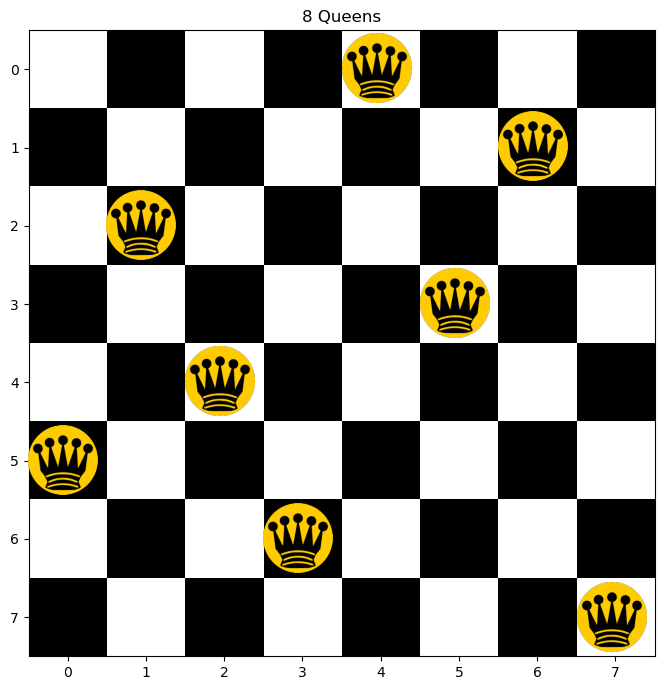

In [27]:
def queen_constraint(A, a, B, b):
    """Constraint is satisfied (true) if A, B are really the same variable,
    or if they are not in the same row, down diagonal, or up diagonal."""
    return A == B or (a != b and A + a != B + b and A - a != B - b)


def plot_NQueens(solution):
    n = len(solution)
    board = np.array([2 * int((i + j) % 2) for j in range(n) for i in range(n)]).reshape((n, n))
    im = Image.open(r'C:\Users\hp\Desktop\Pythonn\_pycache_\instance\queen_s.png')
    height = im.size[1]
    im = np.array(im).astype(np.float64) / 255
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.set_title('{} Queens'.format(n))
    plt.imshow(board, cmap='binary', interpolation='nearest')
    # NQueensCSP gives a solution as a dictionary
    if isinstance(solution, dict):
        for (k, v) in solution.items():
            newax = fig.add_axes([0.064 + (k * 0.112), 0.062 + ((7 - v) * 0.112), 0.1, 0.1], zorder=1)
            newax.imshow(im)
            newax.axis('off')
    fig.tight_layout()
    plt.show()    


class Nquenns(CSP):
    def __init__(self, n):
        CSP.__init__(self, list(range(n)), UniversalDict(list(range(n))), UniversalDict(list(range(n)))
                     , queen_constraint)
        self.rows = [0] * n
        self.ups = [0] * (2 * n - 1)
        self.downs = [0] * (2 * n - 1)

    def nconflicts(self, var, val, assignment):
        n = len(self.variables)
        c = self.rows[val] + self.downs[var + val] + self.ups[var - val + n - 1]
        if assignment.get(var, None) == val:
            c -= 3
        return c

    def assign(self, var, val, assignment):
        """ Assign var, and keep track of conflicts. """
        old_val = assignment.get(var, None)
        if val != old_val:
            if old_val is not None:  # Remove old val if there was one
                self.record_conflict(assignment, var, old_val, -1)
            self.record_conflict(assignment, var, val, +1)
            CSP.assign(self, var, val, assignment)

    def unassign(self, var, assignment):
        """Remove var from assignment (if it is there) and track conflicts."""
        if var in assignment:
            self.record_conflict(assignment, var, assignment[var], -1)
        CSP.unassign(self, var, assignment)

    def record_conflict(self, assignment, var, val, delta):
        """Record conflicts caused by addition or deletion of a Queen."""
        n = len(self.variables)
        self.rows[val] += delta
        self.downs[var + val] += delta
        self.ups[var - val + n - 1] += delta

    def display(self, assignment):
        """Print the queens and the nconflicts values (for debugging)."""
        n = len(self.variables)
        for val in range(n):
            for var in range(n):
                if assignment.get(var, '') == val:
                    ch = 'Q'
                elif (var + val) % 2 == 0:
                    ch = '.'
                else:
                    ch = '-'
                print(ch, end=' ')
            print('    ', end=' ')
            for var in range(n):
                if assignment.get(var, '') == val:
                    ch = '*'
                else:
                    ch = ' '
                print(str(self.nconflicts(var, val, assignment)) + ch, end=' ')
            print()
            
solv = min_conflicts(Nquenns(8))
plot_NQueens(solv)

## 3.3: Sudoku

In [34]:
def flatten(seqs):
    return sum(seqs, [])

_R3 = list(range(3))
_CELL = itertools.count().__next__
_BGRID = [[[[_CELL() for x in _R3] for y in _R3] for bx in _R3] for by in _R3]
_BOXES = flatten([list(map(flatten, brow)) for brow in _BGRID])
_ROWS = flatten([list(map(flatten, zip(*brow))) for brow in _BGRID])
_COLS = list(zip(*_ROWS))

_NEIGHBORS = {v: set() for v in flatten(_ROWS)}
for unit in map(set, _BOXES + _ROWS + _COLS):
    for v in unit:
        _NEIGHBORS[v].update(unit - {v})


class Sudoku(CSP):

    R3 = _R3
    Cell = _CELL
    bgrid = _BGRID
    boxes = _BOXES
    rows = _ROWS
    cols = _COLS
    neighbors = _NEIGHBORS

    def __init__(self, grid):
        squares = iter(re.findall(r'\d|\.', grid))
        domains = {var: [ch] if ch in '123456789' else '123456789'
                   for var, ch in zip(flatten(self.rows), squares)}
        for _ in squares:
            raise ValueError("Not a Sudoku grid", grid)  # Too many squares
        CSP.__init__(self, None, domains, self.neighbors, different_values_constraint)

    def display(self, assignment):
        def show_box(box): return [' '.join(map(show_cell, row)) for row in box]

        def show_cell(cell): return str(assignment.get(cell, '.'))

        def abut(lines1, lines2): return list(
            map(' | '.join, list(zip(lines1, lines2))))

        print('\n------+-------+------\n'.join(
            '\n'.join(reduce(
                abut, map(show_box, brow))) for brow in self.bgrid))        
          
easy1 = '..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..'
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
min_conflicts(Sudoku(easy1))

## 3.4: Crop Prediction and Classification

In [160]:
import pandas as pd
df = pd.read_csv(r"C:\Users\hp\Downloads\Crop_recommendationV2.csv")

def adjust_constraint(val, values):
    crop_col = df[df["label"] == val]
    min_values = crop_col[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'soil_moisture', 
                          'soil_type', 'sunlight_exposure', 'organic_matter', 'fertilizer_usage', 'water_source_type']].min()
    max_values = crop_col[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'soil_moisture', 
                          'soil_type', 'sunlight_exposure', 'organic_matter', 'fertilizer_usage', 'water_source_type']].max()
    return all(min_value <= val <= max_value for val, min_value, max_value in zip(values, min_values, max_values))

domain = {"crop" : df["label"].unique().tolist()}

class Crop(CSP):
    def __init__(self, variables, domains, constraints, Val):
        super().__init__(variables, domains, None, constraints)
        self.values = Val
        
    def nconflicts(self, var, val, assignment):
        """ Return if conflict var=val. """
        return 1 if self.constraints(val, self.values) == False else 0

    def choices(self, var):
        return self.domains[var]
         
    
#[N, P, K, temperature, humidity, ph, rainfall, soil_moisture, soil_type, sunlight_exposure, organic_matter, fertilizer_usage, water_source_type]
Values = [39, 58, 85, 17.25, 16.31, 7.3, 80.06, 20.14, 2, 8.5, 5.01, 119.68, 2]
result = min_conflicts(Crop(domain.keys(), domain, adjust_constraint, Values))
print(result)

{'crop': 'chickpea'}


## 3.5: Stock Market Investment Optimization

In [42]:
# Fetch stock data
def get_stock_data():
    try:
        periode = "6mo" if invest_dur == "short_term" else "5y"       
        scalar = 123 if invest_dur == "short_term" else 252 * 5      
            
        data = yf.download(tickers, period=periode, progress=False)       # Returns a pandas DataFrame
        if data.empty:
            raise ValueError("No data returned for the given tickers.")
                
        adj_close = data['Close']                                              # Consider 'Adj Close' if available
            
        returns = adj_close.pct_change(fill_method=None).mean() * scalar       # adjust by the scalar
        risk = adj_close.pct_change(fill_method=None).std() * (scalar ** 0.5)  
            
        result = pd.DataFrame({"Return": returns, "Risk": risk}, index=tickers) 
        return result
            
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None


# Get the step foot
def get_current_prices():
    prices = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            prices[ticker] = stock.info["currentPrice"]                     # Fetch real-time price
        except KeyError:                                                    
            prices[ticker] = stock.history(period="1d")["Close"].iloc[-1]   # Fallback: Use last close price
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None                                                   
    return prices


# Check constraints
def meets_constraints(var, val, var2, val2):
    msg = []
    total_invested = val + val2
    portfolio_risk = (val * stock_data["Risk"].loc[var] + val2 * stock_data["Risk"].loc[var2]) / total_invested if total_invested!=0 else 0
    max_investment = max(val, val2) / total_invested if total_invested!=0 else 0
    if portfolio_risk > max_risk:
        msg.append(f"Rejected: Portfolio risk {portfolio_risk} exceeds max allowed {max_risk}")
    
    if max_investment > max_invest_per_stock:
        msg.append(f"Rejected: Max single stock investment {max_investment} exceeds allowed {max_invest_per_stock}")
    
    if total_invested > capital:
        msg.append(f"Rejected: Total investment {total_invested} exceeds capital {capital}")

    return 0 if(portfolio_risk <= max_risk and max_investment <= max_invest_per_stock and total_invested <= capital) else 1


#get the domain of each variable (i.e ticker) by increnting step size
def get_domain():
    domain = {}
    for t in tickers:
        domain[t] = [0]
        step = step_sizes[t]
        while step <= capital:
            domain[t].append(step)  # {"TSLA": [0, 500, 1000]}
            step += step
    return domain


#get the neighbors of each variable (i.e ticker)
def get_neighbors():
    neighbors = {}
    for ticker in tickers:
        neighbors[ticker] = [t for t in tickers if t != ticker]
    return neighbors



tickers = [ "ETH-USD" , "AAPL" ,"META" , "TSLA", "RACE" ]
capital = 10000
max_risk = 0.3
max_invest_per_stock = 0.7
invest_dur = "short_term"
stock_data = get_stock_data()
step_sizes =  get_current_prices()
domain = get_domain()
neighbors = get_neighbors()

invest = Backtracking_search(CSP(domain.keys(), domain, neighbors, meets_constraints))
print(invest)

YF.download() has changed argument auto_adjust default to True
{'ETH-USD': 0, 'AAPL': 198.49, 'META': 494.655, 'TSLA': 235.3299, 'RACE': 1778.1}


## 3.6: Ceyptharithmitic Puzzle

In [ ]:
class Crypt(CSP):
    def __init__(self, variables, domains, neighbors, lhs, rhs, rsl):
        super().__init__(variables, domains, neighbors, None)
        self.lhs = lhs
        self.rhs = rhs
        self.rsl = rsl
        
    def nconflicts(self, var, val, assignment):
        """Return the number of conflicts var=val has with other variables."""
        def conflict(var2):
            return var2 in assignment and not self.constraint_crypto(assignment, var, val, var2,  assignment[var2])
        return count(conflict(v) for v in self.neighbors[var])

    def constraint_crypto(self, assignment, var, val, var2, val2):
        if val == val2:
            return 0
        for word in [self.lhs, self.rhs, self.rsl]:
            if word[0] in assignment and assignment[word[0]] == 0:
                return 0     
        full_ass = assignment.copy()
        full_ass[var] = val
        if len(full_ass) == len(self.variables):
            def num(word):
                return sum(full_ass[ch] * (10 ** i) for i, ch in enumerate(reversed(word)))
            if num(self.lhs) + num(self.rhs) != num(self.rsl):
                return 0            
        return 1

    def display(self, assignment):
        lhs_values = [str(assignment[var]) for var in self.lhs]
        rhs_values = [str(assignment[var]) for var in self.rhs]
        rsl_values = [str(assignment[var]) for var in self.rsl]
        
        # Create the string representation of the left-hand side (lhs), right-hand side (rhs), and result (rsl)
        lhs_str = "  ".join(lhs_values)
        rhs_str = "  ".join(rhs_values)
        rsl_str = "  ".join(rsl_values)
        
        # Print the left side, right side, and result
        print(f"{lhs_str}")
        print(f"+ {rhs_str}")
        print("----------")
        print(f"= {rsl_str}")

variables = list('MANREWIS')  # All letters involved
domains = {v: list(range(10)) for v in variables}
neighbors = {v: [u for u in variables if u != v] for v in variables}

# Note: Pass the words as lists of characters in order (left to right)
lhs = list("MEN")
rhs = list("ARE")
rsl = list("WISE")

p = Crypt(variables, domains, neighbors, lhs, rhs, rsl)
s = min_conflicts(p)
if not s:
    p.display(s) 
else : 
    print("cannot found solution")

## 3.7: Password Cracking

In [119]:
class Crack(CSP):
    def __init__(self, variables, domains, neighbors, key, hash_fun = hash):
        super().__init__(variables, domains, neighbors, None)
        self.key = key
        self.hash_fun = hash_fun
        
    def nconflicts(self, var, val, assignment):
        full_assign = assignment.copy()
        full_assign[var] = val
        if len(full_assign) == len(self.variables):
            return 0 if self.hash_fun(''.join(full_assign[i] for i in full_assign)) == self.key else -1
        return 0

variables = ['P0', 'P1', 'P2', 'P3']
domains = {
    'P0' : list(string.ascii_uppercase),
    'P1' : list(string.ascii_lowercase),
    'P2' : list(string.digits),
    'P3' : list("!@#%")
}
key = hash("Ah4@")
neighbors = {v: [u for u in variables if u != v] for v in variables}

Backtracking_search(Crack(variables, domains, neighbors, key = key))

{'P0': 'A', 'P1': 'h', 'P2': '4', 'P3': '@'}

## 3.8: Exam Scheduling

In [140]:
variables = ['1y', '2y', '3y', '4y']
domain = {
    '1y' : [(("09:00-11:00"), 4), (("12:00-14:00"), 4), (("15:00-17:00"), 4)],
    '2y' : [(("09:00-11:00"), 4), (("12:00-14:00"), 4), (("15:00-17:00"), 4)],
    '3y' : [(("09:00-11:00"), 3), (("12:00-14:00"), 3), (("15:00-17:00"), 3)],
    '4y' : [(("09:00-11:00"), 2), (("12:00-14:00"), 2), (("15:00-17:00"), 2)]
}
neighbors = {v: [u for u in variables if u != v] for v in variables}

AVAILBLE_AMPHETRETS = 8

# must give the whole assignment to check also
def met_const(var1, val1, var2, val2):
    per1, pla1 = val1
    per2, pla2 = val2
    if per1 == per2:
        return pla1 + pla2 <= AVAILBLE_AMPHETRETS
    return True

%time Backtracking_search(CSP(variables, domain, neighbors, met_const))

CPU times: total: 0 ns
Wall time: 0 ns


{'1y': ('09:00-11:00', 4),
 '2y': ('09:00-11:00', 4),
 '3y': ('09:00-11:00', 3),
 '4y': ('09:00-11:00', 2)}

## 3.9: Cross Word